# <a id='toc1_'></a>[Name and ID: Hoang Tu Bui - 24005665](#toc0_)

# <a id='toc2_'></a>[The code executes till the end without any errors](#toc0_)

# <a id='toc3_'></a>[Original source:](#toc0_)

1. https://medium.com/@liyinxuan0213/step-by-step-double-deep-q-networks-double-dqn-tutorial-from-atari-games-to-bioengineering-dec7e6373896
1. https://stackoverflow.com/questions/26587527/cite-a-paper-using-github-markdown-syntax

# **Table of contents**<a id='toc0_'></a>    

- [Why Reinforcement Learning is the ML paradigm of choice for this task?](#toc4_)    
- [The Environment](#toc5_)    
- [Implementation](#toc6_)    
  - [Game environment](#toc6_1_)    
    - [Observation from the environment](#toc6_1_1_)    
  - [VANILLA DQN](#toc6_2_)    
    - [Capture and pre-processing of the data](#toc6_2_1_)    
    - [Network structure](#toc6_2_2_)    
    - [Q learning update applied to the weights](#toc6_2_3_)    
    - [Evaluation](#toc6_2_4_)    
      - [Plots](#toc6_2_4_1_)    
      - [How does one evaluate the performance of the RL agent](#toc6_2_4_2_)    
      - [Is the agent learning?](#toc6_2_4_3_)    
  - [DOUBLE DQN](#toc6_3_)    
    - [Problem](#toc6_3_1_)    
    - [Theoretical solution](#toc6_3_2_)    
    - [Evaluation](#toc6_3_3_)    
- [Compare DQN and Double DQN](#toc7_)    
- [Added Value](#toc8_)    
  - [Hyperparamerter Optimization](#toc8_1_)    
  - [Prioritised Experience Replay](#toc8_2_)    
  - [Discussions](#toc8_3_)    
- [References](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc4_'></a>[Why Reinforcement Learning is the ML paradigm of choice for this task?](#toc0_)

Reinforcement Learning (RL) is well-suited for Atari games like Breakout where an agent must learn to make decisions through trial and error, optimizing its actions based on feedback in the form of rewards. This paradigm is distinct from supervised learning, which relies on pre-labeled data, and unsupervised learning, which seeks to find patterns without any labeled responses ([Shaheen et al., 2025](#deepmind-ateri-2025)).

In Breakout, the agent must learn to control a paddle to bounce a ball and break bricks, receiving rewards only when bricks are broken. This setup presents a challenge where the agent must learn the consequences of its actions over time, making RL an ideal approach . ​

The success of RL in Breakout not only showcases its effectiveness in gaming but also highlights its potential in real-world applications where decision-making under uncertainty and learning from interaction are crucial.​

In summary, RL's framework aligns seamlessly with the challenges presented by Breakout, making it the machine learning paradigm of choice for such tasks.​

# <a id='toc5_'></a>[The Environment](#toc0_)

1. The game selected: **Breakout**

    The goal is to control a paddle in order to hit a ball toward brick walls at the top of the screen and to break them ([AtariAge - Atari 2600 Manuals (HTML) - Breakout (Atari), 1997-1998](#breakout-description)). The player starts with 5 lives and loses a life if the ball drops. The game terminates and resets when all lives are lost.

1. The input from the environment: A 210x160 RGB image frame from the game screen, where each pixel value is an unsigned 8-bit integer ranging from 0 to 255 ([Implementation/Game environment](#game-environment)).

1. The control settings: four Discrete actions ([Machado et al., 2018](#ale-breakout-doc)):
    - 0:NOOP (No Operation)
    - 1:FIRE
    - 2:RIGHT
    - 3:LEFT

# <a id='toc6_'></a>[Implementation](#toc0_)

## <a id='toc6_1_'></a>[Game environment](#toc0_)

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


Action space: Discrete(4)
Observation space: Box(0, 255, (210, 160, 3), uint8)


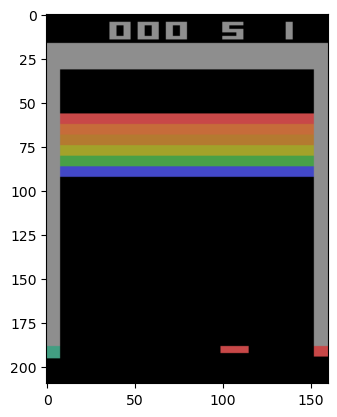

In [1]:
import ale_py
import gymnasium as gym
import matplotlib.pyplot as plt


gym.register_envs(ale_py)
org_env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")

print(f"Action space: {org_env.action_space}")
print(f"Observation space: {org_env.observation_space}")

org_env.reset()
rgb_arr = org_env.render()

assert rgb_arr is not None, "Rendering empty array"
plt.imshow(rgb_arr)
plt.show()

<a id="obs-preprocess"></a> 
<!-- I noticed that the observation includes redundant information — specifically, the scoreboard at the top, which takes up 20 pixels. Thus they will be cut of using Gymnasium Wrappers.  -->
<!-- Finally, a Normalize wrapper scales pixel value from [0,255] to [0,1]. -->

The preprocess applied to the observations include:

1. RecordEpisodeStatistics: keeps track of cumulative rewards and episode lengths.
1. ResizeObservation((84, 84)): resizes the input frame to 84x84 in order to ensure the input to be in fixed size and reduce computation
1. GrayscaleObservation: reduces input dimensionality from 3 channels (rgb) to 1 (gray) while preserving essential information
1. FrameStackObservation(4): Stacks the last 4 grayscale frames together to provide temporal context
    <!-- 1. EpisodicLifeEnv: Mark the loss of life as end of episode but does not reset the environment. [Shaheen et al., 2025](#deepmind-ateri-2025) found out that it helps value estimation -->
1. MaxAndSkipObservation(skip=4): reduces computation and removes flickering artifacts 
1. FireResetEnv: For certain games like Breakout, after life loss, the game is fixed until firing

***MY PROPRIETARY IMPLEMENTATION***: 
1. **FireResetEnv**: In our tests, this wrapper improved cumulative rewards by 80% compared to baseline. However, results were obtained over fewer episodes than [Mnih et al. (2015)](#deepmind-ateri-2015)'s work, requiring further verification.

1. **Wrappers that hindered learning**:
    - **EpisodicLifeEnv**: Artificially terminates episodes on life loss, potentially disrupting long-term strategy learning
    - **Scoreboard removal**: Cropping observations eliminates crucial game state information (lives, score) that could inform better decisions

Above are some of my findings for the agent observation - some show great improvement while others hinder learning. To confirm these effects conclusively, more rigorous testing is needed.

In [ ]:
from stable_baselines3.common.atari_wrappers import (
    MaxAndSkipEnv,
    FireResetEnv,
)

# record episode reward and length
env = gym.wrappers.RecordEpisodeStatistics(org_env)
# Resize from 210x160 to 84x84
env = gym.wrappers.ResizeObservation(env, (84, 84))
# Convert rgb to grayscale
env = gym.wrappers.GrayscaleObservation(env)
# Stack 4 frames for temporal information
env = gym.wrappers.FrameStackObservation(env, 4)
# Only change action every 4th frame
env = MaxAndSkipEnv(env, skip=4)
# Reset with FIRE action
env = FireResetEnv(env)

### <a id='toc6_1_1_'></a>[Observation from the environment](#toc0_)

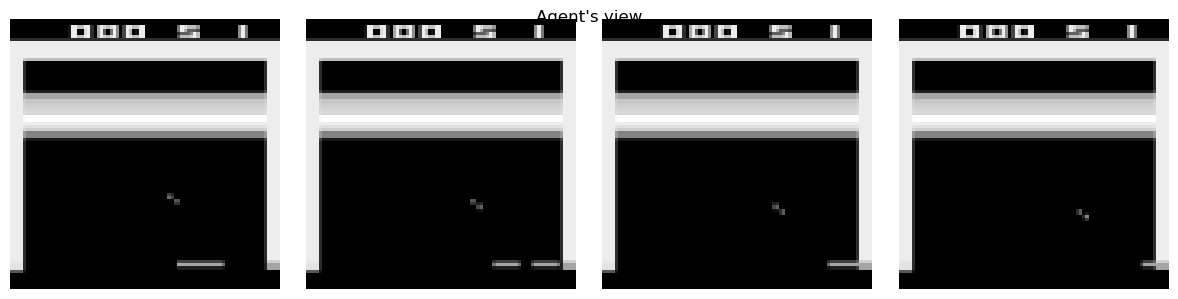

In [ ]:
obs, _ = env.reset()

# plot 4 channels of the observation
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axes[i].imshow(obs.squeeze()[i], cmap="gray")
    axes[i].axis("off")
plt.tight_layout()
fig.suptitle("Agent's view")
plt.show()

## <a id='toc6_2_'></a>[VANILLA DQN](#toc0_)

### <a id='toc6_2_1_'></a>[Capture and pre-processing of the data](#toc0_)

Explained in section [Game environment](#obs-preprocess)

### <a id='toc6_2_2_'></a>[Network structure](#toc0_)

The Deep Q-Network (DQN) implemented here is a convolutional neural network designed to process stacks of image frames, typical in Atari-based reinforcement learning environments. The architecture follows the structure used in the original DeepMind DQN paper by [Mnih et al. (2015)](#deepmind-ateri-2015).
The input to the network is a tensor of shape (4, 84, 84), representing four stacked grayscale frames.

The layers are as follows:

1. **Convolutional Layer 1**

   * `in_channels = 4`, `out_channels = 32`, `kernel_size = 8`, `stride = 4`
   * Output shape: `(32, 20, 20)`

2. **ReLU Activation**

3. **Convolutional Layer 2**

   * `in_channels = 32`, `out_channels = 64`, `kernel_size = 4`, `stride = 2`
   * Output shape: `(64, 9, 9)`

4. **ReLU Activation**

5. **Convolutional Layer 3**

   * `in_channels = 64`, `out_channels = 64`, `kernel_size = 3`, `stride = 1`
   * Output shape: `(64, 7, 7)`

6. **ReLU Activation**

7. **Flatten Layer**

   * Flattens the output from shape `(64, 7, 7)` to a vector of length `3136` (i.e., `64*7*7`)

8. **Fully Connected Layer 1**

   * `in_features = 3136`, `out_features = 512`

9. **ReLU Activation**

10. **Fully Connected Output Layer**

    * `in_features = 512`, `out_features = n_actions`
    * Outputs one Q-value per discrete action.


**In short**, the network extracts spatial features from the input frames using convolutional layers, then maps them through fully connected layers to a Q-value for each possible action.

In [ ]:
from torch import nn


class DQN(nn.Module):
    def __init__(self, n_actions):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
        )

    def forward(self, x):
        return self.network(x / 255.0)  # Normalize to [0, 1]


print(DQN(4))

DQN(
  (network): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=4, bias=True)
  )
)


### <a id='toc6_2_3_'></a>[Q learning update applied to the weights](#toc0_)

In this implementation, Deep Q-Learning is used to train a neural network to approximate the optimal action-value function $Q^*(s, a)$. The network parameters are updated using samples from a Replay Buffer, with the target computed from a fixed target network.

At every train_freq steps (e.g. every 4 steps), if enough transitions are stored, the following update is applied:

1. The weights are updated to minimize the **Huber loss** between the predicted Q-value and the target:

    $$
    \text{Loss} = \text{Huber}(Q(s_t, a_t) - y_t)
    $$

    where the **target** $y_t$ is defined as:

    $$
    y_t = r_t + \gamma \cdot \max_{a'} Q_{\text{target}}(s_{t+1}, a') \cdot (1 - \text{done})
    $$

    Here:

    * $Q(s_t, a_t)$: is the estimated Q-value from the online network for the selected action
    * $Q_{\text{target}}(s_{t+1}, a')$: is the max predicted Q-value from the target network
    * $r_t$: is the clipped reward at time $t$
    * $\gamma$: is the discount factor
    * $\text{done}$: is a binary flag indicating episode termination

1. Mechanics

    1. Sample a minibatch of transitions $(s, a, r, s', \text{done})$ from the replay buffer
    2. Compute current Q-values for $s$ using the online network
    3. Compute target Q-values for $s'$ using the target network (no gradients)
    4. Compute loss between current and target Q-values using `F.huber_loss`
    5. Backpropagate the loss and update the online network weights via Adam optimizer
    6. Every $C$ steps, **synchronize the target network** with the online network


***MY PROPRIETARY IMPLEMENTATION***: 
1. `Huber Loss` instead of `MSE`.

    The Huber loss function is used in Deep Q-Networks (DQNs) as a compromise between mean squared error (MSE) and mean absolute error (MAE). Unlike MSE, which heavily penalizes large errors and can lead to unstable gradients, Huber loss behaves quadratically for small errors (ensuring smooth optimization) and linearly for large errors (preventing explosive gradients from outliers). The Huber loss thus contributes to more stable and reliable convergence compared to pure MSE.



In [5]:
import copy
from gymnasium import Env
from stable_baselines3.common.buffers import ReplayBuffer
import torch
from torch.optim.adam import Adam
import torch.nn.functional as F
import random
import numpy as np


def calEpsilon(epoch, epsilon_start, epsilon_end, exploration_steps):
    return max(
        (epsilon_end - epsilon_start) / exploration_steps * epoch + epsilon_start,
        epsilon_end,
    )


def DQN_train(
    env: Env,
    model: nn.Module,
    device="cuda",
    buffer_size=10_000,
    n_epoch=30_000,
    train_freq=4,
    batch_size=96,
    gamma=0.99,
    replay_start_size=50,
    epsilon_start=1,
    epsilon_end=0.1,
    exploration_steps=1_000,
    C=10,  # Target network update frequency
    learning_rate=1.25e-4,
    verbose=False,
):

    # Initialize replay memory D to capacity N
    rb = ReplayBuffer(
        buffer_size,
        env.observation_space,
        env.action_space,
        device,
        optimize_memory_usage=True,
        handle_timeout_termination=False,
    )

    # Initialize target action-value function Q_hat
    targetNetwork = copy.deepcopy(model).to(device)
    # Initialize action-value function Q with random weights
    onlineNetwork = model.to(device)
    targetNetwork.load_state_dict(onlineNetwork.state_dict())

    optimizer = Adam(onlineNetwork.parameters(), lr=learning_rate)

    epoch = 0
    total_rewards_list = []
    smoothed_rewards = []
    rewards = []
    total_loss_list = []
    loss_means = []
    losses = []
    best_reward = 0
    bestState = {}

    while epoch <= n_epoch:

        dead = False
        total_rewards = 0

        # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
        obs, _ = env.reset()

        for _ in range(random.randint(1, 30)):  # Noop and fire to reset environment
            obs, reward, terminated, truncated, info = env.step(1)

        while not dead:
            current_life = info["lives"]

            epsilon = calEpsilon(epoch, epsilon_start, epsilon_end, exploration_steps)
            if random.random() < epsilon:  # With probability ε select a random action a
                action = np.array(env.action_space.sample())

            else:  # Otherwise select a = max_a Q∗(φ(st), a; θ)
                q_values = onlineNetwork(torch.Tensor(obs).unsqueeze(0).to(device))
                action = np.array(torch.argmax(q_values, dim=1).item())

            # Execute action a in emulator and observe reward rt and image xt+1
            next_obs, reward, terminated, truncated, info = env.step(action)
            dead = terminated or truncated

            # print(f"info: {info}")
            done = np.array(info["lives"] < current_life)

            # Set st+1 = st, at, xt+1 and preprocess φt+1 = φ(st+1)
            real_next_obs = next_obs.copy()

            reward = float(reward)
            total_rewards += reward
            reward = np.sign(reward)  # Reward clipping

            # Store transition (φt, at, rt, φt+1) in D
            rb.add(obs, real_next_obs, action, reward, done, [info])

            obs = next_obs

            if epoch > replay_start_size and epoch % train_freq == 0:
                # Sample random minibatch of transitions (φj , aj , rj , φj +1 ) from D
                data = rb.sample(batch_size)
                with torch.no_grad():
                    max_target_q_value, _ = targetNetwork(data.next_observations).max(
                        dim=1
                    )
                    y = data.rewards.flatten() + gamma * max_target_q_value * (
                        1 - data.dones.flatten()
                    )
                current_q_value = (
                    onlineNetwork(data.observations).gather(1, data.actions).squeeze()
                )

                loss = F.huber_loss(y, current_q_value)

                # Perform a gradient descent
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            # Every C steps reset Q_hat=Q
            if epoch % C == 0:
                targetNetwork.load_state_dict(onlineNetwork.state_dict())

            epoch += 1
            if (epoch % 10_000 == 0) and epoch > 0:
                smoothed_reward = np.mean(rewards) if rewards else 0
                smoothed_rewards.append(smoothed_reward)
                total_rewards_list.append(rewards)
                rewards = []

                loss_mean = np.mean(losses) if losses else 0
                loss_means.append(loss_mean)
                total_loss_list.append(losses)
                losses = []

            if verbose and (epoch % 100_000 == 0):
                print(
                    f"Epoch: {epoch}, Loss: {loss_mean}, Smoothed Reward: {smoothed_reward}"
                )

        rewards.append(total_rewards)

        if total_rewards > best_reward:
            best_reward = total_rewards
            bestState = onlineNetwork.state_dict()

    return bestState, total_rewards_list, total_loss_list

In [ ]:
assert isinstance(env.action_space, gym.spaces.Discrete), "Action space is not discrete"
model = DQN(env.action_space.n)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

trainConfigs = {
    "buffer_size": 100_000,
    "n_epoch": 500_000,
    "batch_size": 96,
    "gamma": 0.99,
    "replay_start_size": 5_000,
    "epsilon_start": 1,
    "epsilon_end": 0.1,
    "exploration_steps": 100_000,
    "C": 1_000,
    "learning_rate": 1.25e-4,
}

(
    modelState,
    rewardss,
    losseses,
) = DQN_train(
    env,
    model,
    device=device,
    verbose=True,
    **trainConfigs,
)

Using device: cuda


Epoch: 100000, Loss: 0.08187664746195078, Smoothed Reward: 7.648648648648648


Epoch: 200000, Loss: 0.058545749221742154, Smoothed Reward: 11.855421686746988


Epoch: 300000, Loss: 0.07806080380529165, Smoothed Reward: 14.373333333333333


Epoch: 400000, Loss: 0.07348397461920976, Smoothed Reward: 15.0


Epoch: 500000, Loss: 0.08560453231111169, Smoothed Reward: 15.301369863013699


### <a id='toc6_2_4_'></a>[Evaluation](#toc0_)

#### <a id='toc6_2_4_1_'></a>[Plots](#toc0_)

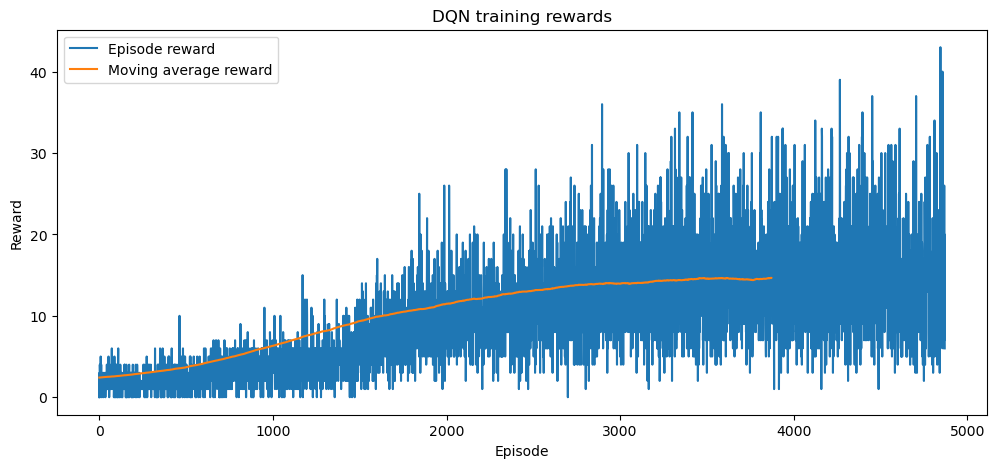

In [7]:
# unwrap the rewardss
unwrappedRewards = [item for sublist in rewardss for item in sublist]

# plot rewards over episodes
plt.figure(figsize=(12, 5))
plt.plot(unwrappedRewards, label="Episode reward")
# add moving average (1000)
plt.plot(
    np.convolve(unwrappedRewards, np.ones(1000) / 1000, mode="valid"),
    label="Moving average reward",
)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN training rewards")
plt.legend()
plt.show()

The plot shows the raw reward for each episode and the moving average reward (smoothed over 1000 eps). The moving average increase consistently showing that the agent is learning

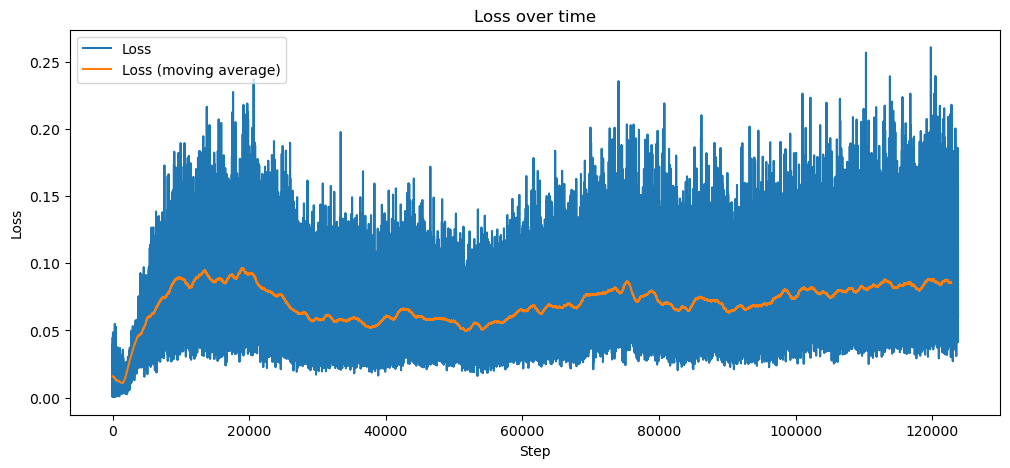

In [8]:
unwrappedLosses = [item for sublist in losseses for item in sublist]
# plot losses
plt.figure(figsize=(12, 5))
plt.plot(unwrappedLosses, label="Loss")
# add moving average (1000)
plt.plot(
    np.convolve(unwrappedLosses, np.ones(1000) / 1000, mode="valid"),
    label="Loss (moving average)",
)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss over time")
plt.legend()
plt.show()

The plot shows the loss for each iteration step and the moving average loss (smoothed over 1000 eps). The loss fluctuates because the agent figured the better actions overtime and the model not only had to adjust to old knowledge but also the new infomation.

#### <a id='toc6_2_4_2_'></a>[How does one evaluate the performance of the RL agent](#toc0_)

The performance of a reinforcement learning (RL) agent is typically evaluated by measuring its average return (or score) over a number of episodes in the target environment. In the case of Atari games, this is done by running the trained agent in the environment for several test episodes — often with no learning updates — and computing the mean cumulative reward per episode. To ensure fair evaluation, the environment is usually initialized with random "no-op" actions or using human start positions to assess generalization. These evaluations are often repeated multiple times and averaged to reduce variance.

For better interpretability, results are often normalized using human-level and random-agent scores, as done in the Arcade Learning Environment ([Machado et al., 2018](#ale-breakout-doc)). A common metric is the human-normalized score:

$$
\text{Normalized Score} = 100 \times \frac{\text{Agent Score} - \text{Random Score}}{\text{Human Score} - \text{Random Score}}
$$

This allows performance comparisons across games with very different score scales. 

Additionally, **learning curves** (reward vs. training steps) help visualize how quickly and reliably the agent improves during training. 


***For this project, to evaluate if the agent is learning, I focus primarily on learning curves***

In [9]:
def play(model: nn.Module, env: Env, device, n_episodes, render):
    model.to(device)
    model.eval()

    frames = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        dead = False

        # start with fire option
        action = 1

        while not dead:
            obs, _, terminated, truncated, _ = env.step(action)

            dead = terminated or truncated

            if len(frames) < render:
                frames.append(env.render())

            with torch.no_grad():
                obs_tensor = torch.tensor(obs).unsqueeze(0).to(device)

                q_values = model(obs_tensor)
                action = np.array(torch.argmax(q_values, dim=1).item())

            if terminated or truncated:
                action = 1

    return frames

In [ ]:
from matplotlib import animation
from IPython.display import HTML


model.load_state_dict(modelState)

# Play the game
frames = play(model, env, "cpu", n_episodes=3, render=1000)

# Keep 3_rd frames
frames = [frames[i] for i in range(0, len(frames), 3)]

print(f"Drawing {len(frames)} frames")
fig = plt.figure()
plt.axis("off")
im = plt.imshow(frames[0])


def update_frame(frame):
    im.set_data(frame)
    return [im]


ani = animation.FuncAnimation(fig, update_frame, frames=frames, interval=50)
plt.close(fig)
HTML(ani.to_jshtml())

Drawing 220 frames


#### <a id='toc6_2_4_3_'></a>[Is the agent learning?](#toc0_)

From both the plots and the short play above, **the agent is learning**.

## <a id='toc6_3_'></a>[DOUBLE DQN](#toc0_)

### <a id='toc6_3_1_'></a>[Problem](#toc0_)

One of the key problems with Vanilla DQN is its tendency to overestimate Q-values during training. This happens because the max operator used in the Q-learning update selects the highest estimated action value, which tends to be overly optimistic due to noise and approximation errors in the value function ([van Hasselt et al., 2016](#double-dqn)).
This overestimation can lead to unstable learning and suboptimal policies, especially in environments with noisy or sparse rewards. As training progresses, these compounded overestimations can mislead the policy into favoring incorrect actions.

### <a id='toc6_3_2_'></a>[Theoretical solution](#toc0_)

Double DQN addresses this overestimation bias by **decoupling action selection from action evaluation**. Instead of using the same network to both select and evaluate the next action, Double DQN uses:

* The **online network** to select the best action (argmax),
* The **target network** to evaluate the Q-value of that action.

Mathematically, the target value becomes:

$$
Q_{\text{target}}(s,a) = r + \gamma \, Q_{\text{target}}\bigl(s', \arg\max_{a'} Q_{\text{online}}(s',a')\bigr)
$$

This separation reduces the chance of overestimating Q-values because the evaluation is less biased by the same noisy estimates used for selection.


In [11]:
def doubleDQN_train(
    env: Env,
    model: nn.Module,
    device="cuda",
    buffer_size=10_000,
    n_epoch=30_000,
    train_freq=4,
    batch_size=96,
    gamma=0.99,
    replay_start_size=50,
    epsilon_start=1,
    epsilon_end=0.1,
    exploration_steps=1_000,
    C=10,  # Target network update frequency
    learning_rate=1.25e-4,
    verbose=False,
):

    # Initialize replay memory D to capacity N
    rb = ReplayBuffer(
        buffer_size,
        env.observation_space,
        env.action_space,
        device,
        optimize_memory_usage=True,
        handle_timeout_termination=False,
    )

    # Initialize target action-value function Q_hat
    targetNetwork = copy.deepcopy(model).to(device)
    # Initialize action-value function Q with random weights
    onlineNetwork = model.to(device)
    targetNetwork.load_state_dict(onlineNetwork.state_dict())

    optimizer = Adam(onlineNetwork.parameters(), lr=learning_rate)

    epoch = 0
    total_rewards_list = []
    smoothed_rewards = []
    rewards = []
    total_loss_list = []
    loss_means = []
    losses = []
    best_reward = 0
    bestState = {}

    while epoch <= n_epoch:

        dead = False
        total_rewards = 0

        # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
        obs, _ = env.reset()

        for _ in range(random.randint(1, 30)):  # Noop and fire to reset environment
            obs, reward, terminated, truncated, info = env.step(1)

        while not dead:
            current_life = info["lives"]

            epsilon = max(
                (epsilon_end - epsilon_start) / exploration_steps * epoch
                + epsilon_start,
                epsilon_end,
            )
            if random.random() < epsilon:  # With probability ε select a random action a
                action = np.array(env.action_space.sample())

            else:  # Otherwise select a = max_a Q∗(φ(st), a; θ)
                q_values = onlineNetwork(torch.Tensor(obs).unsqueeze(0).to(device))
                action = np.array(torch.argmax(q_values, dim=1).item())

            # Execute action a in emulator and observe reward rt and image xt+1
            next_obs, reward, terminated, truncated, info = env.step(action)
            dead = terminated or truncated

            # print(f"info: {info}")
            done = np.array(info["lives"] < current_life)

            # Set st+1 = st, at, xt+1 and preprocess φt+1 = φ(st+1)
            real_next_obs = next_obs.copy()

            reward = float(reward)
            total_rewards += reward
            reward = np.sign(reward)  # Reward clipping

            # Store transition (φt, at, rt, φt+1) in D
            rb.add(obs, real_next_obs, action, reward, done, [info])

            obs = next_obs

            if epoch > replay_start_size and epoch % train_freq == 0:
                # Sample random minibatch of transitions (φj , aj , rj , φj +1 ) from D
                data = rb.sample(batch_size)
                with torch.no_grad():
                    # Use the online network to select the action
                    bestActions = onlineNetwork(data.next_observations).argmax(
                        dim=1, keepdim=True
                    )
                    # Use the target network to evaluate the action
                    nextQ_val = (
                        targetNetwork(data.next_observations)
                        .gather(1, bestActions)
                        .squeeze()
                    )
                y = data.rewards.flatten() + (
                    gamma * nextQ_val * (1 - data.dones.flatten())
                )
                current_q_value = (
                    onlineNetwork(data.observations).gather(1, data.actions).squeeze()
                )

                loss = F.huber_loss(y, current_q_value)

                # Perform a gradient descent
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            # Every C steps reset Q_hat=Q
            if epoch % C == 0:
                targetNetwork.load_state_dict(onlineNetwork.state_dict())

            epoch += 1
            if (epoch % 10_000 == 0) and epoch > 0:
                smoothed_reward = np.mean(rewards) if rewards else 0
                smoothed_rewards.append(smoothed_reward)
                total_rewards_list.append(rewards)
                rewards = []

                loss_mean = np.mean(losses) if losses else 0
                loss_means.append(loss_mean)
                total_loss_list.append(losses)
                losses = []

            if verbose and (epoch % 100_000 == 0):
                print(
                    f"Epoch: {epoch}, Loss: {loss_mean}, Smoothed Reward: {smoothed_reward}"
                )

        rewards.append(total_rewards)

        if total_rewards > best_reward:
            best_reward = total_rewards
            bestState = onlineNetwork.state_dict()

    return bestState, total_rewards_list, total_loss_list

In [ ]:
assert isinstance(env.action_space, gym.spaces.Discrete), "Action space is not discrete"
model = DQN(env.action_space.n)


modelState, rewardss, losseses = doubleDQN_train(
    env,
    model,
    device=device,
    verbose=True,
    **trainConfigs,
)

Epoch: 100000, Loss: 0.06536651483252645, Smoothed Reward: 7.571428571428571


Epoch: 200000, Loss: 0.05287798437997699, Smoothed Reward: 12.487804878048781


Epoch: 300000, Loss: 0.06841784616485239, Smoothed Reward: 13.256410256410257


Epoch: 400000, Loss: 0.07311122519522906, Smoothed Reward: 14.277777777777779


Epoch: 500000, Loss: 0.08716579149663449, Smoothed Reward: 13.666666666666666


### <a id='toc6_3_3_'></a>[Evaluation](#toc0_)

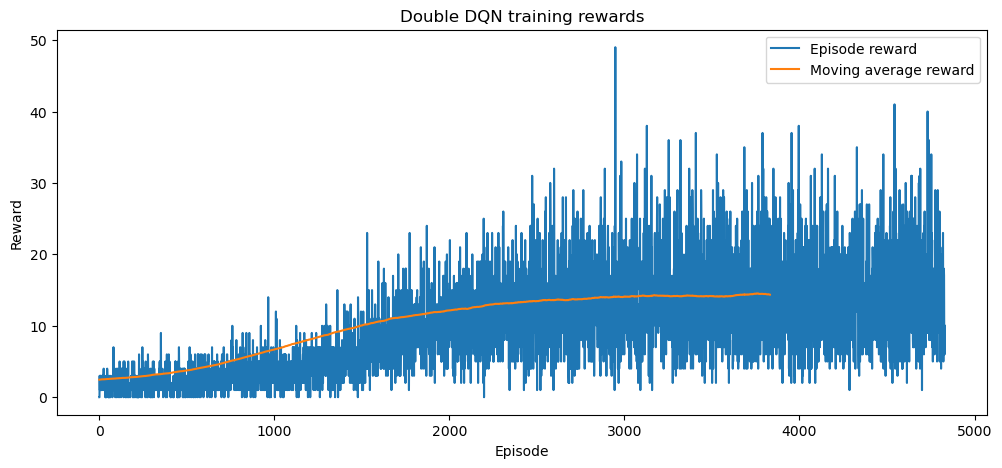

In [13]:
unwrappedRewards = [item for sublist in rewardss for item in sublist]
# plot rewards over episodes
plt.figure(figsize=(12, 5))
plt.plot(unwrappedRewards, label="Episode reward")
# add moving average (1000)
plt.plot(
    np.convolve(unwrappedRewards, np.ones(1000) / 1000, mode="valid"),
    label="Moving average reward",
)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Double DQN training rewards")
plt.legend()
plt.show()

The plot shows the raw reward for each episode and the moving average reward (smoothed over 1000 eps). The moving average increase consistently showing that the agent is learning

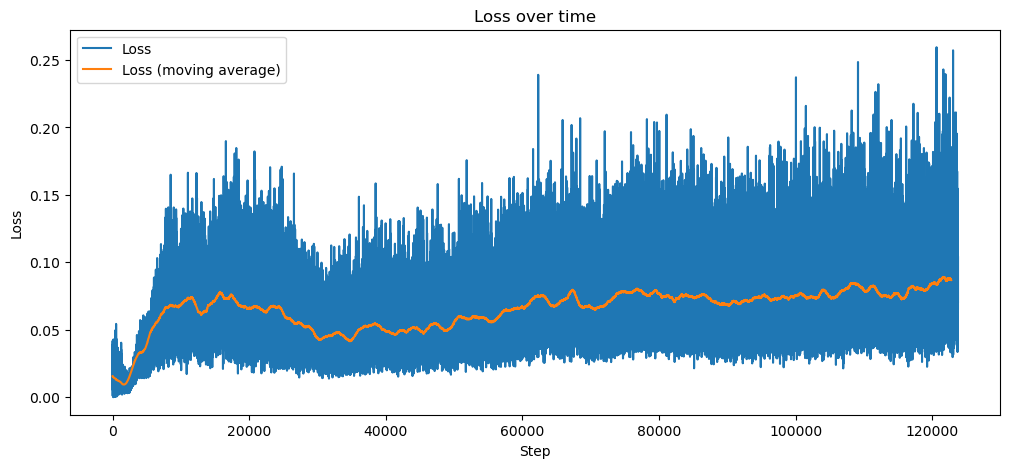

In [14]:
unwrappedLosses = [item for sublist in losseses for item in sublist]
# plot losses over steps
plt.figure(figsize=(12, 5))
plt.plot(unwrappedLosses, label="Loss")
# add moving average (1000)
plt.plot(
    np.convolve(unwrappedLosses, np.ones(1000) / 1000, mode="valid"),
    label="Loss (moving average)",
)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss over time")
plt.legend()
plt.show()

The plot shows the loss for each iteration step and the moving average loss (smoothed over 1000 eps). The loss fluctuates because the agent figured the better actions overtime and the model not only had to adjust to old knowledge but also the new infomation.

In [15]:
from matplotlib import animation
from IPython.display import HTML


model.load_state_dict(modelState)

# Play the game
frames = play(model, env, "cpu", n_episodes=3, render=1000)

# Keep 3_rd frames
frames = [frames[i] for i in range(0, len(frames), 3)]

print(f"Drawing {len(frames)} frames")
fig = plt.figure()
plt.axis("off")
im = plt.imshow(frames[0])


def update_frame(frame):
    im.set_data(frame)
    return [im]


ani = animation.FuncAnimation(fig, update_frame, frames=frames, interval=50)
plt.close(fig)
HTML(ani.to_jshtml())

Drawing 215 frames


**The Agent is also learning** with double DQN.

# <a id='toc7_'></a>[Compare DQN and Double DQN](#toc0_)

In our experiments, we observed that **Vanilla DQN** learns faster than Double DQN, achieving higher cumulative rewards in the early stages of training. This is likely due to DQN’s inherent **overestimation bias**, which can encourage more aggressive exploration and faster short-term reward accumulation. 

However, as training progresses, this overestimation can result in unstable value estimates and suboptimal policy choices. In contrast, **Double DQN** addresses this issue by decoupling action selection from evaluation, leading to more conservative but stable learning. While it starts slower, Double DQN typically catches up and may outperform Vanilla DQN in the later phases of training, especially in environments with noisy or delayed rewards.

The greater stability of Double DQN is evident in the plots above: Vanilla DQN shows more fluctuation and a larger range of values for both reward and loss. This supports the theoretical advantage of Double DQN in producing more consistent learning dynamics over time.


# <a id='toc8_'></a>[Added Value](#toc0_)

## <a id='toc8_1_'></a>[Hyperparamerter Optimization](#toc0_)

[Ken Zheng (2024)](#hyperparam-2024) investigates the impact of hyperparameter tuning on the performance of popular deep reinforcement learning (DRL) algorithms, specifically DDPG, TRPO, and PPO, across three continuous control environments from MuJoCo: HalfCheetah, Hopper, and Walker2d. The motivation stems from the widely acknowledged sensitivity of DRL algorithms to hyperparameter settings, yet many practitioners still rely on default configurations.

To address this, the authors employ BOHB (Bayesian Optimization with Hyperband), an efficient hyperparameter optimization method that balances exploration and exploitation while being budget-aware. They define a search space of nine hyperparameters per algorithm and conduct extensive evaluations to understand how tuning affects final episodic return and sample efficiency. The study compares optimized configurations against default baselines and demonstrates that optimized parameters can significantly boost performance, especially for DDPG and TRPO.

A key finding is that even modest tuning budgets lead to meaningful gains, and blindly using defaults can result in suboptimal performance. However, they also show diminishing returns beyond a certain tuning effort, and that tuning results can be environment-specific. The work emphasizes the importance of systematic tuning in DRL and provides insights into which parameters and search strategies are most impactful.

Below are the comparision of their paramerters and mine:

| **Parameter**            | **Paper's Tuned Value**                             | **My Value**    | **Notes / Comparison**                                                                  |
| ------------------------ | --------------------------------------------------- | ----------------- | --------------------------------------------------------------------------------------- |
| `batch_size`             | `84`                                                | `96`              | Similar. Marginal difference — likely low impact unless memory is a concern.            |
| `gamma`                  | `0.95298`                                           | `0.99`            | I discount future rewards more — they found a slightly more short-term focus better.  |
| `learning_rate`          | `6.6566e-5`                                         | `1.25e-4`         | Mine makes training faster; theirs is more conservative and possibly more stable.          |
| `replay_start_size`      | `50000`                                             | `5000`              |  they delay learning until buffer is filled more. Prevents early bias. |
| `target_update`          | `2500`                                              | `1000` (my `C`)   | Their target network updates less frequently. This might add more stability.           |
| `exploration_steps`      | - | `100_000`            | Their exploration comprises of 2 linear phrases 1->0.1->0.01, over 1 million then 22 million of frames while mine is one linear decaying over 100_000 frames.   |


In [16]:
tunnedConfigs = {
    "buffer_size": 100_000,
    "n_epoch": 500_000,
    "batch_size": 84,
    "gamma": 0.95298,
    "replay_start_size": 50_000,
    "epsilon_start": 0.147,
    "epsilon_end": 0.1,
    "exploration_steps": 100_000,
    "C": 2500,
    "learning_rate": 6.6566e-5,
}


# their way of calculating decay epsilon
# full epsilon range is from 1.0 → 0.1 → 0.01, transitioning across:
# Step 2 to 1,000,000: Decay from 1.0 → 0.1
# Step 1,000,000 to 22,000,000: Decay from 0.1 → 0.01
# After 22M steps: Fixed ε = 0.01


def calEpsilon(epoch, epsilon_start, epsilon_end, exploration_steps):
    current_step = epoch
    startpoint = 2
    end = 0.1
    kneepoint = 1_000_000
    final_eps = 0.01
    final_knee_point = 22_000_000

    if current_step < startpoint:
        return 1
    mid_seg = end + np.maximum(
        0, (1 - end) - (1 - end) / kneepoint * (current_step - startpoint)
    )
    if not final_eps:
        return mid_seg
    else:
        if final_eps and final_knee_point and (current_step < kneepoint):
            return mid_seg
        else:
            return final_eps + (end - final_eps) / (final_knee_point - kneepoint) * (
                final_knee_point - current_step
            )


assert isinstance(env.action_space, gym.spaces.Discrete), "Action space is not discrete"
model = DQN(env.action_space.n)

modelState, rewardss, losseses = doubleDQN_train(
    env,
    model,
    device=device,
    verbose=True,
    **tunnedConfigs,
)

Epoch: 100000, Loss: 0.00560063635087572, Smoothed Reward: 4.809523809523809


Epoch: 200000, Loss: 0.0107298613011837, Smoothed Reward: 7.925233644859813


Epoch: 300000, Loss: 0.012541193152125926, Smoothed Reward: 11.011111111111111


Epoch: 400000, Loss: 0.013521971985232086, Smoothed Reward: 12.246913580246913


Epoch: 500000, Loss: 0.017041521983779968, Smoothed Reward: 11.764705882352942


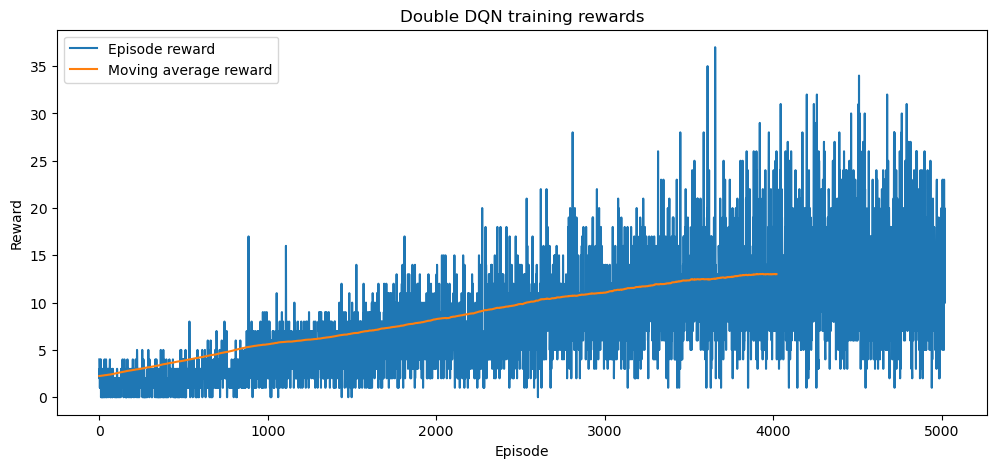

In [17]:
unwrappedRewards = [item for sublist in rewardss for item in sublist]
# plot rewards over episodes
plt.figure(figsize=(12, 5))
plt.plot(unwrappedRewards, label="Episode reward")
# add moving average (1000)
plt.plot(
    np.convolve(unwrappedRewards, np.ones(1000) / 1000, mode="valid"),
    label="Moving average reward",
)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Double DQN training rewards")
plt.legend()
plt.show()

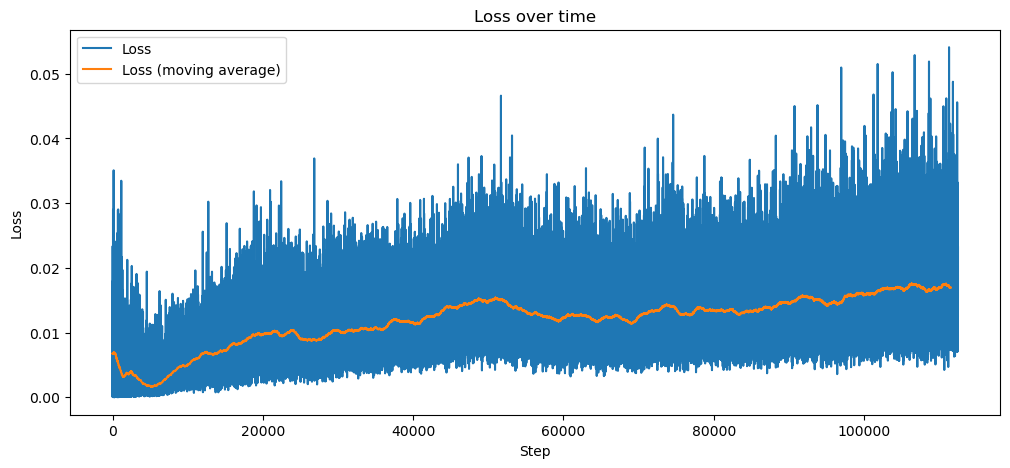

In [ ]:
unwrappedLosses = [item for sublist in losseses for item in sublist]
# plot losses over steps
plt.figure(figsize=(12, 5))
plt.plot(unwrappedLosses, label="Loss")
# add moving average (1000)
plt.plot(
    np.convolve(unwrappedLosses, np.ones(1000) / 1000, mode="valid"),
    label="Loss (moving average)",
)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss over time")
plt.legend()
plt.show()

## <a id='toc8_2_'></a>[Prioritised Experience Replay](#toc0_)

Prioritized Experience Replay (PER) is a technique that improves learning efficiency by sampling transitions from the replay buffer based on their importance rather than uniformly. Unlike standard experience replay, where all transitions have an equal chance of being selected, PER assigns higher priority to transitions with larger temporal-difference (TD) errors—indicating that the agent can learn more from these experiences. The priorities are calculated using the absolute TD error, and sampling is adjusted using hyperparameters `α` (which controls the prioritization strength) and `β` (which corrects bias introduced by non-uniform sampling). By focusing on more informative experiences, PER accelerates learning and helps the agent converge faster to an optimal policy. This method was introduced by [Schaul et al. (2015)](#PER) and has since become a standard enhancement in deep reinforcement learning, particularly in environments with sparse rewards where only a few transitions are highly informative.  


In [19]:
from torchrl.data import PrioritizedReplayBuffer, ListStorage


def prioritisedDoubleDQN_train(
    env: Env,
    model: nn.Module,
    device="cuda",
    buffer_size=10_000,
    n_epoch=30_000,
    train_freq=4,
    batch_size=96,
    gamma=0.99,
    replay_start_size=50,
    epsilon_start=1,
    epsilon_end=0.1,
    exploration_steps=1_000,
    C=10,  # Target network update frequency
    learning_rate=1.25e-4,
    verbose=False,
):

    # Initialize replay memory D to capacity N
    rb = PrioritizedReplayBuffer(
        storage=ListStorage(buffer_size),
        alpha=0.7,
        beta=0.5,
        batch_size=batch_size,
        pin_memory=True,
    )

    # Initialize target action-value function Q_hat
    targetNetwork = copy.deepcopy(model).to(device)
    # Initialize action-value function Q with random weights
    onlineNetwork = model.to(device)
    targetNetwork.load_state_dict(onlineNetwork.state_dict())

    optimizer = Adam(onlineNetwork.parameters(), lr=learning_rate)

    epoch = 0
    total_rewards_list = []
    smoothed_rewards = []
    rewards = []
    total_loss_list = []
    loss_means = []
    losses = []
    best_reward = 0
    bestState = {}

    while epoch <= n_epoch:

        dead = False
        total_rewards = 0

        # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
        obs, _ = env.reset()

        for _ in range(random.randint(1, 30)):  # Noop and fire to reset environment
            obs, reward, terminated, truncated, info = env.step(1)

        while not dead:
            current_life = info["lives"]

            epsilon = max(
                (epsilon_end - epsilon_start) / exploration_steps * epoch
                + epsilon_start,
                epsilon_end,
            )
            if random.random() < epsilon:  # With probability ε select a random action a
                action = np.array(env.action_space.sample())

            else:  # Otherwise select a = max_a Q∗(φ(st), a; θ)
                q_values = onlineNetwork(torch.Tensor(obs).unsqueeze(0).to(device))
                action = np.array(torch.argmax(q_values, dim=1).item())

            # Execute action a in emulator and observe reward rt and image xt+1
            next_obs, reward, terminated, truncated, info = env.step(action)
            dead = terminated or truncated

            # print(f"info: {info}")
            done = np.array(info["lives"] < current_life)

            # Set st+1 = st, at, xt+1 and preprocess φt+1 = φ(st+1)
            real_next_obs = next_obs.copy()

            reward = float(reward)
            total_rewards += reward
            reward = np.sign(reward)  # Reward clipping

            # Store transition (φt, at, rt, φt+1) in D
            rbData = {
                "obs": torch.tensor(obs),
                "next_obs": torch.tensor(real_next_obs),
                "action": torch.tensor(action),
                "reward": torch.tensor(reward),
                "done": torch.tensor(done),
                # "info": torch.tensor(info),
            }
            rb.add(rbData)

            obs = next_obs

            if epoch > replay_start_size and epoch % train_freq == 0:
                # Sample random minibatch of transitions (φj , aj , rj , φj +1 ) from D
                rbData, rbInfo = rb.sample(batch_size, True)
                for k, v in rbData.items():
                    rbData[k] = v.float().to(device)

                with torch.no_grad():
                    # Use the online network to select the action
                    bestActions = onlineNetwork(rbData["next_obs"]).argmax(
                        dim=1, keepdim=True
                    )
                    # Use the target network to evaluate the action
                    nextQ_val = (
                        targetNetwork(rbData["next_obs"])
                        .gather(1, bestActions)
                        .squeeze()
                    )
                y = rbData["reward"].flatten() + (
                    gamma * nextQ_val * (1 - rbData["done"].flatten())
                )
                current_q_value = (
                    onlineNetwork(rbData["obs"])
                    .gather(1, rbData["action"].to(torch.int64).unsqueeze(-1))
                    .squeeze()
                )

                loss = F.huber_loss(y, current_q_value)

                # cal the priority
                tdErr = (y - current_q_value).abs()
                rb.update_priority(rbInfo["index"], tdErr)

                # Perform a gradient descent
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            # Every C steps reset Q_hat=Q
            if epoch % C == 0:
                targetNetwork.load_state_dict(onlineNetwork.state_dict())

            epoch += 1
            if (epoch % 10_000 == 0) and epoch > 0:
                smoothed_reward = np.mean(rewards) if rewards else 0
                smoothed_rewards.append(smoothed_reward)
                total_rewards_list.append(rewards)
                rewards = []

                loss_mean = np.mean(losses) if losses else 0
                loss_means.append(loss_mean)
                total_loss_list.append(losses)
                losses = []

            if verbose and (epoch % 100_000 == 0):
                print(
                    f"Epoch: {epoch}, Loss: {loss_mean}, Smoothed Reward: {smoothed_reward}"
                )

        rewards.append(total_rewards)

        if total_rewards > best_reward:
            best_reward = total_rewards
            bestState = onlineNetwork.state_dict()

    return bestState, total_rewards_list, total_loss_list

In [ ]:
assert isinstance(env.action_space, gym.spaces.Discrete), "Action space is not discrete"
model = DQN(env.action_space.n)

modelState, rewardss, losseses = prioritisedDoubleDQN_train(
    env,
    model,
    device=device,
    verbose=False,
    **trainConfigs,
)

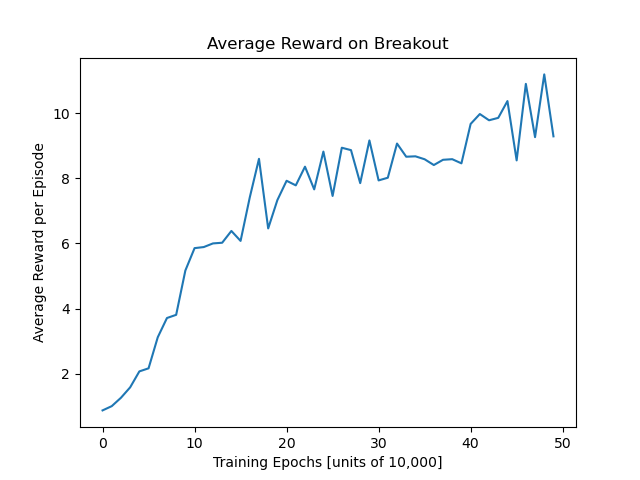

In [ ]:
meanRewards = np.mean(unwrappedRewards, axis=1)
plt.plot(meanRewards)
plt.title("Average Reward on Breakout")
plt.xlabel("Training Epochs [units of 10,000]")
plt.ylabel("Average Reward per Episode")
plt.show()

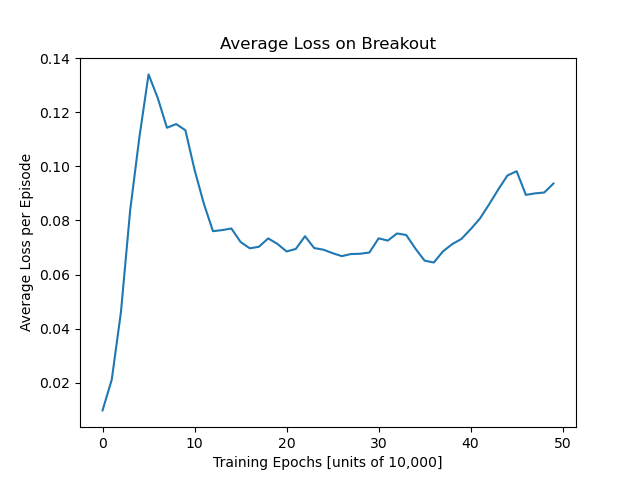

In [ ]:
meanLosses = np.mean(unwrappedLosses, axis=1)
plt.plot(meanLosses)
plt.title("Average Loss on Breakout")
plt.xlabel("Training Epochs [units of 10,000]")
plt.ylabel("Average Loss per Episode")
plt.show()

## <a id='toc8_3_'></a>[Discussions](#toc0_)

[Mnih et al. (2015)](#deepmind-ateri-2015) discussed performance across different Atari games and explained why Vanilla DQN works well or poorly in certain games. 
For games like Breakout, Pong, Robotank, ... where the agent reaches **Superhuman** performance because the environment sends frequent and immediate rewards.
In contrast, games like Seaquest and Pitfall feature sparse rewards, requiring long sequences of correct actions before any feedback is received — leading the DQN agent to perform worse than a human, and sometimes even worse than a random policy.

One fundamental weakness of Vanilla DQN is its tendency to overestimate action values due to the use of the max operator in Q-learning updates. 
This overestimation bias significantly impacts games like Seaquest, where noisy reward signals can mislead the value function. 
To address this, [van Hasselt et al. (2016)](#double-dqn) introduced Double DQN, which decouples action selection and evaluation by using separate networks. This significantly reduces overestimation bias and leads to more stable and accurate learning, especially in environments where DQN struggles.

Rainbow DQN [(Hessel et al., (2017))](#rainbow-dqn-hyperparam) represents a significant advancement in value-based reinforcement learning by integrating six major improvements into the original Deep Q-Network (DQN) framework. These enhancements were selected to address distinct limitations of DQN, such as overestimation bias, inefficient learning from experience, poor exploration, and delayed reward propagation. Together, they form a unified agent that delivers robust and consistent performance across a broad set of environments.

The six components that make up Rainbow DQN include: (1) Double DQN, which mitigates overestimation by decoupling action selection and evaluation during the Q-learning update; (2) Prioritized Experience Replay, which samples transitions based on their learning potential rather than uniformly, significantly improving data efficiency; (3) Dueling Network Architecture, which separates the estimation of state value and advantage for each action, improving generalization in states with similar-valued actions; (4) Multi-step Learning, which uses n-step returns to propagate rewards faster and reduce variance in updates; (5) Distributional RL, which models the entire distribution of possible future returns instead of just the expected value; and (6) Noisy Networks, which replace traditional exploration strategies like ε-greedy with parameterized stochasticity in the network weights to encourage better exploration.

Empirical results on 57 Atari 2600 games demonstrated that Rainbow significantly outperforms all individual baselines, both in terms of data efficiency and final score. For example, it matched the original DQN’s final performance in just 7 million environment frames and exceeded the best baseline performance by 44 million frames. In terms of final evaluation, Rainbow achieved a median human-normalized score of 223% in the no-op start regime and 153% in the human start regime. Ablation studies further revealed that multi-step learning and prioritized replay were the most impactful components; removing either resulted in a substantial performance drop. Overall, Rainbow illustrates how combining complementary techniques can lead to substantial gains in stability, speed, and accuracy in deep reinforcement learning.





# <a id='toc9_'></a>[References](#toc0_)

1. <a id="breakout-description"></a>
AtariAge—Atari 2600 Manuals (HTML)—Breakout (Atari). (1997-1998). Retrieved May 5, 2025, from https://atariage.com/manual_html_page.php?SoftwareID=889

1. <a id="ale-breakout-doc"></a>
Machado, M. C., Bellemare, M. G., Talvitie, E., Veness, J., Hausknecht, M. J., & Bowling, M. (2018). Revisiting the Arcade Learning Environment: Evaluation Protocols and Open Problems for General Agents. Journal of Artificial Intelligence Research, 61, 523–562.
https://ale.farama.org/environments/breakout/

1. <a id="deepmind-ateri-2025"></a>
Shaheen, A., Badr, A., Abohendy, A., Alsaadawy, H., & Alsayad, N. (2025). Reinforcement Learning in Strategy-Based and Atari Games: A Review of Google DeepMinds Innovations (No. arXiv:2502.10303). arXiv. https://doi.org/10.48550/arXiv.2502.10303

1. <a id="deepmind-ateri-2015"></a>
Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., Graves, A., Riedmiller, M., Fidjeland, A. K., Ostrovski, G., Petersen, S., Beattie, C., Sadik, A., Antonoglou, I., King, H., Kumaran, D., Wierstra, D., Legg, S., & Hassabis, D. (2015). Human-level control through deep reinforcement learning. Nature, 518(7540), 529–533. https://doi.org/10.1038/nature14236

1. <a id="hyperparam-2024"></a>
Zheng, Ken. (2024). Hyperparameter Optimization for Deep Reinforcement Learning: An Atari Breakout Case Study. 10.58445/rars.1635. 

1. <a id="double-dqn"></a>
van Hasselt, H., Guez, A., & Silver, D. (2016). Deep Reinforcement Learning with Double Q-Learning. Proceedings of the AAAI Conference on Artificial Intelligence, 30(1). https://doi.org/10.1609/aaai.v30i1.10295

1. <a id="rainbow-dqn-hyperparam"></a>
Hessel, M., Modayil, J., Hasselt, H. van, Schaul, T., Ostrovski, G., Dabney, W., Horgan, D., Piot, B., Azar, M., & Silver, D. (2017). Rainbow: Combining Improvements in Deep Reinforcement Learning (No. arXiv:1710.02298). arXiv. https://doi.org/10.48550/arXiv.1710.02298

1. <a id="PER"></a>
Schaul, T., Quan, J., Antonoglou, I., & Silver, D. (2015). Prioritized experience replay. arXiv preprint arXiv:1511.05952.